In [146]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Examine series of models trained with 03_cvae_multi script

In [147]:
import os
import pandas as pd
import itertools
import jax
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bioreaction.misc.misc import flatten_listlike
from evoscaper.model.evaluation import calc_prompt_adherence
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict, write_json
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation

from evoscaper.utils.preprocess import make_datetime_str

jax.config.update('jax_platform_name', 'cpu')

# sns.set_context("notebook")
sns.set_style("whitegrid")


In [149]:
# Merge if too many seperate folders
import shutil


def find_dirs_merge(dir_top, fn_varying, fn_basic):
    dirs_found = []
    for d in os.listdir(dir_top):
        try:
            config = load_json_as_dict(os.path.join(
                dir_top, d, 'config_multisim.json'))
            if fn_varying in config.get('fn_varying', None) and fn_basic in config.get('fn_basic', None):
                dirs_found.append(os.path.join(dir_top, d))
        except FileNotFoundError:
            continue
    return sorted(dirs_found)


def load_batch_results(dir_source, name_default):
    use_dict = name_default.endswith('.json')
    result = {} if use_dict else None
    sorted_dir_batches = sorted(os.listdir(os.path.join(
        dir_source, 'batch_results')), key=lambda x: int(x.split('_')[-1].split('.')[0]))
    for dir_batch in sorted_dir_batches:
        fn_result_batch = os.path.join(
            dir_source, 'batch_results', dir_batch, name_default)
        if use_dict:
            result_batch = load_json_as_dict(fn_result_batch)
            for k, v in result_batch.items():
                if k not in result:
                    result[k] = []
                result[k].extend(v)
        else:
            result_batch = np.load(fn_result_batch)
            if result is None:
                result = result_batch
            else:
                result = np.concatenate((result, result_batch), axis=0)
    return result


def load_analytics_batch(dir_source):
    return load_batch_results(dir_source, 'analytics.json')


def load_all_numpy_batch(dir_source):
    ts = load_batch_results(dir_source, 'ts.npy')
    ts0 = load_batch_results(dir_source, 'ts0.npy')
    y0m = load_batch_results(dir_source, 'y0m.npy')
    y00s = load_batch_results(dir_source, 'y00s.npy')
    ys = load_batch_results(dir_source, 'ys.npy')
    return ts, ts0, y0m, y00s, ys


def merge_dicts(d, dict_full):
    for k, v in d.items():
        if k not in dict_full:
            dict_full[k] = []
        dict_full[k].extend(v)
    return dict_full


def merge_nps(nps, np_full):
    for i, arg in enumerate(nps):
        if np_full[i] is None:
            np_full[i] = arg
        else:
            np_full[i] = np.concatenate((np_full[i], arg), axis=0)
    return np_full


def merge_dirs_common(dirs_common, dir_write, reduce_index=False,
                      skip_numpys=False):
    # Merge all the dataframes
    dir_write = sorted(dirs_common)[-1] if dir_write is None else dir_write
    dir_weights_write = os.path.join(dir_write, 'cvae_scan')
    # os.makedirs(dir_weights_write, exist_ok=True)
    dir_sample_write = os.path.join(dir_write, 'sampled_cond')
    os.makedirs(dir_sample_write, exist_ok=True)
    df_full = pd.DataFrame()
    analytics, config_run = {}, {}
    ts, ts0, y0m, y00s, ys = None, None, None, None, None
    for d in dirs_common:
        # config
        config_run_d = load_json_as_dict(
            os.path.join(d, 'config_multisim.json'))
        config_run_d['dir_source'] = d
        config_run[len(df_full)] = config_run_d

        # df
        df = pd.read_json(os.path.join(d, 'df_hpos.json'))
        if reduce_index:
            df = df[~df.index.isin(df_full.index)]

        # sampled cond
        dir_sample = os.path.join(d, 'sampled_cond')
        for i, fn in enumerate(sorted(os.listdir(dir_sample))):
            idx_og = int(fn.split('.')[0].split('_')[-1])
            d_curr = df.reset_index()[df.reset_index()['index'] == idx_og]
            if not len(d_curr):
                continue
            idx_new = d_curr.index[0] + len(df_full)
            fn_sample_new = os.path.join(
                dir_sample_write, f'sampled_cond_{idx_new}.npy')
            shutil.copy2(os.path.join(dir_sample, fn), fn_sample_new)

        # df full
        if len(df_full) and reduce_index:
            df_full = df_full[df_full['run_successful']
                              != 'TO_BE_RECORDED']
        df_full = pd.concat([df_full, df], ignore_index=not (reduce_index)).reset_index(drop=True)

        # model weights
        fn_weights_map = {}
        dir_weights_all = os.path.join(d, 'cvae_scan')
        for i, dir_weights in enumerate(sorted(os.listdir(dir_weights_all))):
            d_curr = df_full[df_full['filename_saved_model'].str.endswith(dir_weights)]
            if not len(d_curr):
                continue
            idx_new = d_curr.index[0] + len(df_full)
            dir_weights_old = os.path.join(dir_weights_all, dir_weights)
            dir_weights_new = os.path.join(dir_weights_write, f'hpo_{idx_new}')
            fn_weights_map[idx_new] = (dir_weights_old, dir_weights_new)
            
        for idx_new, (dir_weights_old, dir_weights_new) in fn_weights_map.items():
            df_full.loc[idx_new, 'filename_saved_model'] = dir_weights_new
            shutil.copytree(dir_weights_old, dir_weights_new)

    write_json(df_full.reset_index().to_dict(), os.path.join(dir_write, 'df_hpos.json'), overwrite=True)
    df_full.to_csv(os.path.join(dir_write, 'df_hpos.csv'))
    write_json(config_run, os.path.join(
        dir_write, 'config_multisim_combined.json'))
    
    # analytics
    for d in dirs_common:
        analytics_d = load_analytics_batch(d)
        analytics = merge_dicts(analytics_d, analytics)
    write_json(analytics, os.path.join(dir_write, 'analytics.json'))

    # Numpys
    # if not skip_numpys:
    #     for d in dirs_common:
    #         ts_d, ts0_d, y0m_d, y00s_d, ys_d = load_all_numpy_batch(d)
    #         ts, ts0, y0m, y00s, ys = merge_nps(
    #             [ts_d, ts0_d, y0m_d, y00s_d, ys_d], [ts, ts0, y0m, y00s, ys])
    #     np.save(os.path.join(dir_write, 'ts.npy'), ts)
    #     np.save(os.path.join(dir_write, 'ts0.npy'), ts0)
    #     np.save(os.path.join(dir_write, 'y0m.npy'), y0m)
    #     np.save(os.path.join(dir_write, 'y00s.npy'), y00s)
    #     np.save(os.path.join(dir_write, 'ys.npy'), ys)

    return df_full


do_merge = True

if do_merge:
    fn_varying = "configs/cvae_multi/scan_contloss4.json"
    fn_basic = "configs/cvae_multi/hpos_basic_20250424.json"
    dir_top = 'data/cvae_multi'

    dirs_common = find_dirs_merge(dir_top, fn_varying, fn_basic)
    # d = merge_dirs_common(dirs_common)

    dirs_common

    p = os.path.join('data', 'cvae_multi', '2025_04_28__13_37_39')   # cont loss 3 & 4 combined
    # p = os.path.join('data/cvae_multi', make_datetime_str())
    # os.makedirs(p, exist_ok=True)

    dirs_common = ['data/cvae_multi/2025_04_13__17_42_48', 'data/cvae_multi/2025_04_25__09_20_55']
    df_full = merge_dirs_common(dirs_common, p)

    print(p)


data/cvae_multi/2025_04_28__13_37_39


# Load

In [ ]:
top_write_dir = os.path.join('data', '08_cvae_examine_multi', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

use_single = True
if use_single:
    # dir_source = os.path.join('data', 'cvae_multi', '2025_04_04__10_05_19')  # objectives
    # dir_source = os.path.join('data', 'cvae_multi', '2025_04_09__14_29_05')  # kl div
    # dir_source = os.path.join('data', 'cvae_multi', '2025_04_13__17_42_48')  # cont loss 3
    # dir_source = os.path.join('data', 'cvae_multi', '2025_04_25__09_20_55')  # cont loss 4
    dir_source = os.path.join('data', 'cvae_multi', '2025_04_28__13_37_39')  # cont loss 3 & 4 combined
    # dir_source = os.path.join('data', 'cvae_multi', '2025_04_13__17_51_19')  # Datasize
    # dir_source = os.path.join('data', 'cvae_multi', '2025_04_23__16_23_37')  # objectives 2
    fn_hpos = os.path.join(dir_source, 'df_hpos.json')
    df_hpos = pd.read_json(fn_hpos)
else:
    dir_source = os.path.join('data', '03_cvae_multi', '2025_03_25__13_39_24')
    dirs_source = [os.path.join('data', '03_cvae_multi', k) for k in ['2025_03_24__17_11_20']] #, '2025_02_08__22_15_29', '2025_02_11__13_49_15', '2025_02_11__21_13_15', '2025_02_13__13_38_43']]
    
    # KL div
    dir_source = os.path.join('data', '03_cvae_multi', '2025_03_25__13_39_24')
    dirs_source = [os.path.join('data', '03_cvae_multi', k) for k in ['2025_03_24__17_11_20']] #, '2025_02_08__22_15_29', '2025_02_11__13_49_15', '2025_02_11__21_13_15', '2025_02_13__13_38_43']]
    
    df_hpos = pd.DataFrame()
    for d in dirs_source:
        fn_hpos = os.path.join(d, 'df_hpos_main.json')
        df_hpos_i = pd.read_json(fn_hpos)
        df_hpos = pd.concat([df_hpos, df_hpos_i[df_hpos_i['R2_train'] != 'TO_BE_RECORDED']], axis=0)
    
    fn_hpos = os.path.join(dir_source, 'df_hpos_full.json')
    if not os.path.exists(fn_hpos):
        df_hpos.to_json(fn_hpos)
    
df_hpos = df_hpos[df_hpos['R2_train'] != 'TO_BE_RECORDED']
df_hpos = df_hpos.sort_index()
df_hpos = df_hpos[df_hpos['R2_train'].apply(lambda x: x > 0 if type(x) != str else True)]
df_hpos['mutual_information_conditionality'] = df_hpos['mutual_information_conditionality'].apply(lambda x: np.mean(x) if type(x) == list else x)

config_run = load_json_as_dict(os.path.join(dir_source, 'config_multisim.json'))


In [ ]:
fn_sample = os.path.join(dir_source, 'sampled_cond.npy')
dir_sample = os.path.join(dir_source, 'sampled_cond')
fn_analytics = os.path.join(dir_source, 'analytics.json')
if not os.path.exists(fn_analytics):
    analytics = load_analytics_batch(dir_source)
    write_json(analytics, fn_analytics)
    
if not os.path.exists(dir_sample):
    sampled_cond = np.load(fn_sample)
else:
    sampled_cond = {}
    # sorted_files = sorted(os.listdir(dir_sample), key=lambda x: int(x.split('_')[-1].split('.')[0]))
    for fn in os.listdir(dir_sample):
        sampled_cond[int(fn.split('.')[0].split('_')[-1])] = np.load(os.path.join(dir_sample, fn))
analytics = load_json_as_dict(fn_analytics)

In [ ]:
output_idx = -1
perc_recall=0.01
df_hpos['precision'] = np.nan
df_hpos['recall'] = np.nan
df_hpos['f1'] = np.nan

use_recall = False

if use_recall:
    for i, r in df_hpos.iterrows():
        curr_dir = os.path.dirname(r['filename_saved_model']).replace('notebooks/', '')
        # fn_sample = os.path.join(curr_dir, 'sampled_cond.npy')
        # fn_analytics = os.path.join(curr_dir, 'analytics.json')
        if r['R2_train'] > 0.8: # and os.path.exists(fn_sample) and os.path.exists(fn_analytics):
            # sampled_cond = np.load(fn_sample)
            # analytics = load_json_as_dict(fn_analytics)
            analytics['adaptation'] = calculate_adaptation(
                np.array(analytics['sensitivity']), np.array(analytics['precision']), alpha=2)
            a = np.concatenate([np.array(analytics[k])[..., output_idx][:, None] for k in r['objective_col']], axis=-1).reshape(*sampled_cond.shape)
            precision, recall, f1 = calc_prompt_adherence(sampled_cond, a, perc_recall=perc_recall)
            df_hpos.loc[i, 'precision'] = precision.mean()
            df_hpos.loc[i, 'recall'] = recall.mean()
            df_hpos.loc[i, 'f1'] = f1.mean()



In [ ]:
# cols_bool = ['use_kl_div', 'run_successful']
# for c in cols_bool:
#     df_hpos[c] = df_hpos[c].apply(lambda x: True if x == 'True' else False)
#     df_hpos[c] = df_hpos[c].apply(lambda x: False if x == 'False' else True)
#     df_hpos[c] = df_hpos[c].apply(lambda x: True if x == 'True' else False)
#     df_hpos[c] = df_hpos[c].apply(lambda x: False if x == 'False' else True)

In [ ]:
if 'kl_weight' not in df_hpos.columns:
    df_hpos['kl_weight'] = df_hpos['kl_weight (x10e-4)'] / 1e4
df_hpos['kl_weight (x10e-4)'] = df_hpos['kl_weight'] * 1e4

In [ ]:
df_hpos.loc[~((df_hpos['use_kl_div'] == True) | (df_hpos['use_kl_div'] == 'True')), 'kl_weight'] = np.nan
df_hpos['threshold_early_val_acc'] = df_hpos['threshold_early_val_acc'].apply(np.float32)

df_hpos = df_hpos[(df_hpos['run_successful'] == True) | (df_hpos['run_successful'] == 'True')] # == 'True']
for c in df_hpos.columns:
    if df_hpos[c].dtype == bool:
        df_hpos[c] = df_hpos[c].astype(str)

In [ ]:
# df_hpos['kl_weight'] = df_hpos['kl_weight'] * 1e4
# df_hpos.rename(columns={'kl_weight': 'kl_weight (x10e-4)'}, inplace=True)


# df_hpos.rename(columns={'kl_weight x10e-4': 'kl_weight (x10e-4)'}, inplace=True)
# df_hpos['total_ds_max'] = np.log10(df_hpos['total_ds_max'])
# df_hpos.rename(columns={'total_ds_max': 'Log Total ds'}, inplace=True)
df_hpos['Log Total data'] = np.log10(df_hpos['total_ds_max'] )
df_hpos['Dataset seed'] = df_hpos['seed_dataset']
df_hpos['KL divergence loss'] = df_hpos['use_kl_div']
cols_exclude_renamed = ['total_ds_max', 'seed_dataset', 'use_kl_div']

In [ ]:
from evoscaper.model.evaluation import calculate_distributional_overlap

def calc_overlaps(analytic):
    """ Calculate for 1 sample.
    For analytic, shape is (n_conditions, n_evaluated_per_sample)
    """
    kde = calculate_distributional_overlap(analytic, dist_type='kde')
    overlaps_nodiag = kde[~np.eye(kde.shape[0], dtype=bool)
                          ].reshape(kde.shape[0], -1)
    kde_overlaps = {
        'max': overlaps_nodiag.max(axis=1),
        'min': overlaps_nodiag.min(axis=1),
        'mean': overlaps_nodiag.mean(axis=1),
        'std': overlaps_nodiag.std(axis=1)}
    return kde_overlaps


objective_chosen = 'adaptation'
idx_output = -1
analytics['adaptation'] = calculate_adaptation(
    np.array(analytics['sensitivity']), np.array(analytics['precision']), alpha=2)
a = analytics[objective_chosen][..., idx_output].flatten()
kde_overlaps_all = []
if f'KDE {objective_chosen} min' not in df_hpos.columns:
    
    df_hpos.loc[:, f'KDE {objective_chosen} min'] = np.nan
    df_hpos.loc[:, f'KDE {objective_chosen} max'] = np.nan
    df_hpos.loc[:, f'KDE {objective_chosen} mean'] = np.nan
    df_hpos.loc[:, f'KDE {objective_chosen} std'] = np.nan

    for i, (ir, r) in enumerate(df_hpos[(df_hpos['run_successful'] == 'True') & (df_hpos['R2_train'] > 0.8)].iterrows()):
        # if not r['run_successful']:
        #     continue
        n_categories = r['eval_n_categories']
        eval_n_to_sample = r['eval_n_to_sample']
        
        kde_overlaps = calc_overlaps(
            analytic=a[i*eval_n_to_sample:(i+1) *
                       eval_n_to_sample].reshape(n_categories, -1),
        )
        df_hpos.loc[ir,
                    f'KDE {objective_chosen} min'] = kde_overlaps['min'].mean()
        df_hpos.loc[ir,
                    f'KDE {objective_chosen} max'] = kde_overlaps['max'].mean()
        df_hpos.loc[ir,
                    f'KDE {objective_chosen} mean'] = kde_overlaps['mean'].mean()
        df_hpos.loc[ir,
                    f'KDE {objective_chosen} std'] = kde_overlaps['std'].mean()
        kde_overlaps_all.append(kde_overlaps['mean'])
        # print(r['temperature'], r['seed_train'], kde_overlaps['min'].mean(), kde_overlaps['max'].mean())

    # write_json(df_hpos, fn_hpos)
    df_hpos.to_json(fn_hpos)

In [ ]:
# df_hpos['Overlap mean'] = pd.DataFrame([df_hpos[[f'Overlap {cc}' for cc in c.iloc[0]]].loc[i].apply(lambda x: np.array([np.nan if v is None else v for v in x['mean']]))
#                                                                   for i, c in df_hpos[['objective_col']].iterrows()]).apply(lambda x: x.apply(np.nanmean)).apply(np.nanmean, axis=1)
# df_hpos['Overlap std'] = pd.DataFrame([df_hpos[[f'Overlap {cc}' for cc in c.iloc[0]]].loc[i].apply(lambda x: np.array([np.nan if v is None else v for v in x['std']]))
#                                                                   for i, c in df_hpos[['objective_col']].iterrows()]).apply(lambda x: x.apply(np.nanmean)).apply(np.nanmean, axis=1)

In [ ]:
# df_hpos['Overlap adaptation mean'] = df_hpos['Overlap adaptation'].apply(lambda x: np.array([np.nan if v is None else v for v in x['mean']]) if type(x) != str else x)
# df_hpos['Overlap adaptation std'] = df_hpos['Overlap adaptation'].apply(lambda x: np.array([np.nan if v is None else v for v in x['std']]) if type(x) != str else x)


In [ ]:
if 'kl_div_ave' in df_hpos.columns:
    df_hpos['kl_div_max'] = df_hpos['kl_div_ave'].apply(
        lambda x: np.nanmax(list(x.values())))
    df_hpos['kl_div_mean'] = df_hpos['kl_div_ave'].apply(
        lambda x: np.nanmean(list(x.values())))
df_hpos['Objective'] = df_hpos['objective_col'].apply(lambda x: ',\n'.join(x))

cols_out_verify = ['precision', 'recall', 'f1']
cols_outmetric = ['R2_train', f'KDE {objective_chosen} mean', f'KDE {objective_chosen} min', f'KDE {objective_chosen} max',
                  f'KDE {objective_chosen} std', 'kl_div_mean'] + [c for c in cols_out_verify if (~df_hpos[c].isna().sum() > 0)]
# cols_outmetric = ['R2_train', 'Overlap mean', 'Overlap std', 'kl_div_mean'] + [c for c in cols_out_verify if (~df_hpos[c].isna().sum() > 0)]
cols_latent_stats = ['conditional_entropy', 'condition_entropy_std',
                     'cluster_separation', 'variance_ratio', 'nn_accuracy']
cols_output = cols_outmetric + \
    [i + '_' + k for k in cols_latent_stats for i in flatten_listlike(
        df_hpos['objective_col'].apply(tuple).unique())]
cols_output = [c for c in cols_output if c in df_hpos.columns]

cols_exclude = ['R2_test', 'mutual_information_conditionality', 'objective_col', 'output_species', 'signal_species', 'use_grad_clipping',
                'filenames_train_config', 'kl_div_max', 'kl_div_ave', 'Overlap adaptation', 'Overlap Log sensitivity', 'Overlap Log precision', 'Overlap overshoot/initial',
                'Overlap adaptation mean', 'Overlap adaptation std']
# df_hpos = df_hpos[df_hpos['run_successful'] == 'True']
# df_hpos = df_hpos[(df_hpos != 'TO_BE_RECORDED').all(axis=1)]
cols_input = [c for c in df_hpos.columns if (
    c not in cols_output) and (c not in cols_exclude)]
# for c in df_hpos.columns:
#     if type(df_hpos[c].iloc[0]) == list:
#         df_hpos[c] = df_hpos[c].apply(lambda x: ',\n'.join(x) if (x is not None) and (type(x[0]) == str) else np.array(x))
cols_meta = ['filename_saved_model', 'run_successful', 'info_early_stop', 'error_msg',
             'total_ds', 'n_batches', 'n_layers_enc', 'n_layers_dec', 'eval_n_categories']
cols_exclude = cols_exclude + cols_meta + cols_exclude_renamed
cols_varying = [c for c in cols_input if (
    c not in cols_exclude) and (df_hpos[c].nunique() > 1)]
cols_varying

['seed_train', 'Log Total data', 'Dataset seed']

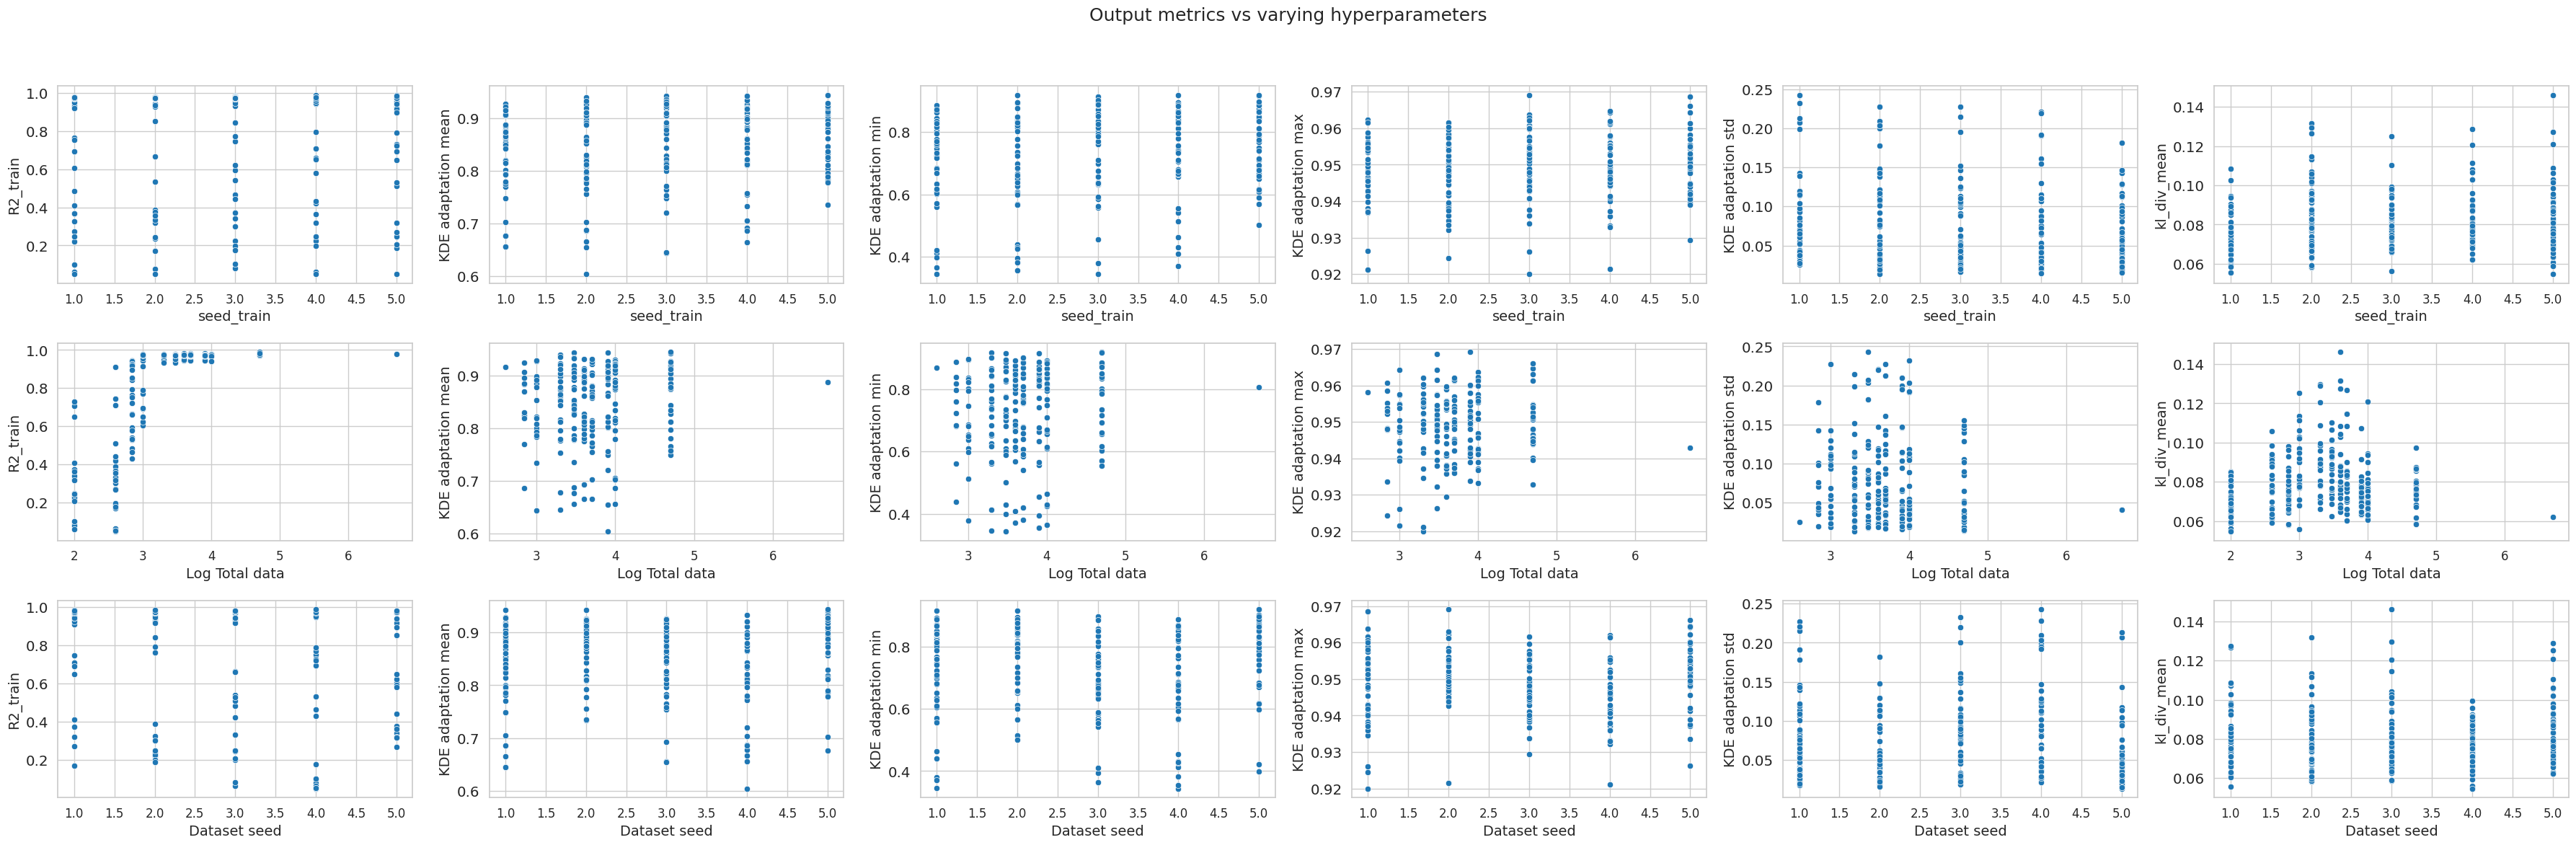

In [ ]:
nrows = len(cols_varying)
ncols = len(cols_outmetric)
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))

if type(sampled_cond) == dict:
    sampled_cond_uniq = np.unique(sampled_cond[list(sampled_cond.keys())[0]])
else:
    sampled_cond_uniq = np.unique(sampled_cond).round(2)
for i, k in enumerate(cols_varying):
    for j, kj in enumerate(cols_outmetric):
        if kj == 'Overlap adpatation mean':
            d_plot = df_hpos[[k]].round(2)
            d_plot[sampled_cond_uniq] = np.vstack(
                df_hpos[kj].values).reshape(-1, len(sampled_cond_uniq)).round(2)
            d_plot = d_plot.melt(
                id_vars=k, var_name='Prompt condition', value_name=kj)
            sns.violinplot(data=d_plot, x=k, y=kj,
                        #    hue='Prompt condition',
                           ax=axes[i, j], palette='viridis',
                           alpha=0.5)
        else:
            sns.scatterplot(data=df_hpos, x=k, y=kj, ax=axes[i, j])
        if k == 'learning_rate':
            axes[i, j].set_xscale('log')
        axes[i, j].tick_params(axis='x', labelsize=12)
        axes[i, j].set_xlabel(k, fontsize=14)
        axes[i, j].set_ylabel(kj, fontsize=14)
plt.suptitle(f'Output metrics vs varying hyperparameters', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig(os.path.join(top_write_dir, 'varying_vs_output_metrics.png'),
            dpi=300, bbox_inches='tight', transparent=True)

# KL Weight

In [ ]:
if 'kl_weight (x10e-4)' in cols_varying:

    cols_outmetric_chosen = [
        'R2_test', f'KDE {objective_chosen} mean'] #, f'KDE {objective_chosen} max']
    titles = [f'$R^2$ validation', f'Overlap between generated\ndistributions per prompt (mean)'] #, 
            #   f'Overlap between generated\ndistributions per prompt (worst)']
    ylabels = [f'$R^2$ validation', 'Distribution overlap'] #, 'KDE overlap (max)']
    fig, axs = plt.subplots(1, len(cols_outmetric_chosen),
                            # figsize=(4*len(cols_outmetric_chosen), 4))
                            figsize=(12, 5))
    for j, kj in enumerate(cols_outmetric_chosen):

        # , linewidth=0.5, linestyle='--')
        sns.lineplot(data=df_hpos, x='kl_weight', y=kj, ax=axs[j])
        g = sns.scatterplot(data=df_hpos, x='kl_weight', y=kj, hue='seed_train', ax=axs[j], s=40, palette='husl',
                            legend=True if j == len(cols_outmetric_chosen) - 1 else False)
        if g.legend_:
            sns.move_legend(g, "upper left",
                            bbox_to_anchor=(1, 1), title='Seed')
        axs[j].set_xlabel('KL weight', fontsize=14)
        ylabel = kj.replace('_', ' ').replace('R2', f'$R^2$') if 'KDE' not in kj else (
            'KDE overlap (mean)' if 'mean' in kj else 'KDE overlap (max)')
        # title = kj.replace('_', ' ').replace(
        #     'R2', f'$R^2$') if 'KDE' not in kj else f'Overlap between generated\ndistributions per prompt {"(worst)" if "max" in kj else "(mean)"}'
        title = titles[j]
        axs[j].set_ylabel(ylabel, fontsize=14)
        axs[j].set_title(title, fontsize=14)
        axs[j].set_xscale('log')
        axs[j].grid(True, which='both', linewidth=0.9)

    plt.suptitle(
        f'Effect of KL divergence loss weight\non network training', fontsize=18)
    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, 'kl_weight_vs_output_metrics.png'),
                dpi=300, bbox_inches='tight', transparent=True)

# Objectives + seeds

In [ ]:
df_hpos['Objective'].unique()

array(['adaptation'], dtype=object)

In [ ]:
if 'Objective' in cols_varying:
    
    df_hpos['Overlap mean'] = pd.DataFrame([df_hpos[[f'Overlap {cc}' for cc in c.iloc[0]]].loc[i].apply(lambda x: np.nanmean([np.nan if v is None else v for v in x['mean']]))
                                                                      for i, c in df_hpos[['objective_col']].iterrows()]).apply(np.nanmean, axis=1)
    df_hpos['Overlap std'] = pd.DataFrame([df_hpos[[f'Overlap {cc}' for cc in c.iloc[0]]].loc[i].apply(lambda x: np.nanmean([np.nan if v is None else v for v in x['std']]))
                                                                      for i, c in df_hpos[['objective_col']].iterrows()]).apply(np.nanmean, axis=1)
    
    # titles_map = {
    #     'adaptation': 'Adaptation',
    #     'Log sensitivity': f'$Log_{10}$ sensitivity',
    #     'Log sensitivity,\nLog precision': f'$Log_{10}$ precision\n$Log_{10}$ precision',
    #     'Log sensitivity,\nLog precision,\novershoot/initial': f'$Log_{10}$ sensitivity\n$Log_{10}$ precision\nOvershoot/initial',
    # }
    # df_hpos['Objective'] = df_hpos['Objective'].apply(lambda x: titles_map.get(x, x))
    df_hpos['Objective'] = df_hpos['Objective'].str.replace('Log ', f'$Log_{{10}}$ ').apply(lambda o: '\n'.join([iii.capitalize() if not iii.startswith('$') else iii for iii in o.split('\n')]))
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_hpos, x='Objective', y='Overlap mean', palette='viridis')
    plt.title('Overlap between prompt distributions by training objective', fontsize=16)
    plt.xticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, 'objective_vs_overlap_box.png'),
                dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
if 'Objective' in cols_varying:
    data = pd.read_json(df_hpos['filenames_train_table'].unique()[0].replace('notebooks/', ''))
    data['adaptation'] = calculate_adaptation(data['sensitivity'].values, data['precision'].values, alpha=2)

    # Make reverse sampled condition as adaptation equivalent
    sampled_cond_adapt = np.zeros((len(sampled_cond), df_hpos['eval_n_to_sample'].iloc[0]))
    filt = data['sample_name'] == 'RNA_2'

    for i, (idx, c) in enumerate(zip(df_hpos.index, df_hpos['objective_col'].values)):
        v = sampled_cond[idx]
        # if 'adaptation' in c:
        #     vv = np.interp(v, (v.min(), v.max()), (np.nanmin(data[filt]['adaptation']), np.nanmax(data[filt]['adaptation'])))
        #     sampled_cond_adapt[i] = vv.flatten()
        if ('Log sensitivity' in c) and ('Log precision' in c):
            s = v[..., c.index('Log sensitivity')]
            s = np.power(10, np.interp(s, (np.nanmin(s), np.nanmax(s)), (np.nanmin(data[filt]['Log sensitivity']), np.nanmax(data[filt]['Log sensitivity']))))
            p = v[..., c.index('Log precision')]
            p = np.power(10, np.interp(p, (np.nanmin(p), np.nanmax(p)), (np.nanmin(data[filt]['Log precision']), np.nanmax(data[filt]['Log precision']))))
            sampled_cond_adapt[i] = calculate_adaptation(s, p, alpha=2).flatten()
            sampled_cond_adapt[i] = np.interp(sampled_cond_adapt[i], (np.nanmin(sampled_cond_adapt[i]), np.nanmax(sampled_cond_adapt[i])), (np.nanmin(v), np.nanmax(v)))
        # elif 'Log sensitivity' in c:
        #     vv = np.interp(v, (v.min(), v.max()), (np.nanmin(data[filt]['Log sensitivity']), np.nanmax(data[filt]['Log sensitivity'])))
        #     sampled_cond_adapt[i] = vv.flatten()
        else:
            sampled_cond_adapt[i] = v.flatten()
    # sampled_cond_adapt = sampled_cond_adapt.flatten()

<Axes: ylabel='Density'>

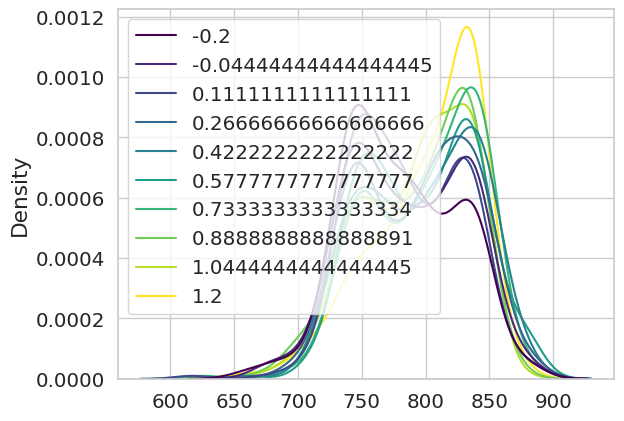

In [ ]:
i = 0
sns.kdeplot(x=analytics['adaptation'].reshape(-1, 3000, 9)[i, :, idx_output].flatten(), hue=sampled_cond[i].flatten(), palette='viridis')

In [ ]:
# fake_circuits0 = np.load('/workdir/notebooks/data/cvae_multi/2025_04_13__17_42_48/fake_circuits.npy')
# fake_circuits1 = np.load('/workdir/notebooks/data/cvae_multi/2025_04_23__16_23_37/fake_circuits.npy')
# fake_circuits0[2], fake_circuits1[2]

In [ ]:
sampled_cond0 = np.load('/workdir/notebooks/data/cvae_multi/2025_04_13__17_42_48/sampled_cond/sampled_cond_0.npy')
sampled_cond1 = np.load('/workdir/notebooks/data/cvae_multi/2025_04_23__16_23_37/sampled_cond/sampled_cond_0.npy')
sampled_cond0.mean(axis=1).flatten(), sampled_cond1.mean(axis=1).flatten()


(array([-0.2       , -0.04444444,  0.11111111,  0.26666667,  0.42222222,
         0.57777778,  0.73333333,  0.88888889,  1.04444444,  1.2       ]),
 array([-0.2       , -0.04444444,  0.11111111,  0.26666667,  0.42222222,
         0.57777778,  0.73333333,  0.88888889,  1.04444444,  1.2       ]))

In [ ]:
# ys0b0 = np.load('/workdir/notebooks/data/cvae_multi/2025_04_13__17_42_48/batch_results/batch_0/ys.npy')
# ys1b1 = np.load('/workdir/notebooks/data/cvae_multi/2025_04_23__16_23_37/batch_results/batch_0/ys.npy')

# i = np.random.randint(0, 10000)
# plt.figure()
# plt.plot(ys0b0[i])
# plt.figure()
# plt.plot(ys1b1[i])
# ys0b0.shape, ys1b1.shape, i

# bad_indexes = [4273, 3855, 9776, 4115, 6567, 6966]

# np.where((fake_circuits0[:len(fake_circuits1)] == fake_circuits1).sum(axis=1).sum(axis=1) > 0)[0].shape

In [ ]:
# a0 = load_json_as_dict('/workdir/notebooks/data/cvae_multi/2025_04_13__17_42_48/batch_results/batch_0/analytics.json')
# a1 = load_json_as_dict('/workdir/notebooks/data/cvae_multi/2025_04_23__16_23_37/analytics.json')
# a1b0 = load_json_as_dict('/workdir/notebooks/data/cvae_multi/2025_04_23__16_23_37/batch_results/batch_0/analytics.json')
# a1b1 = load_json_as_dict('/workdir/notebooks/data/cvae_multi/2025_04_23__16_23_37/batch_results/batch_1/analytics.json')

In [ ]:
# np.array(a0['sensitivity']).shape, np.array(a1['sensitivity']).shape, np.array(a1b0['sensitivity']).shape, np.array(a1b1['sensitivity']).shape

In [ ]:
# np.array(a0['sensitivity'])[0], np.array(a1['sensitivity'])[0], np.array(a1b0['sensitivity'])[0], np.array(a1b1['sensitivity'])[0]

In [ ]:
if 'Objective' in cols_varying:
    
    sns.set_style("whitegrid")
    
    analytics['sensitivity'] = np.where(np.log10(analytics['sensitivity']) < -10, 0, analytics['sensitivity'])
    analytics['precision'] = np.where(np.log10(analytics['precision']) < -10, 0, analytics['sensitivity'])
    analytics['adaptation'] = calculate_adaptation(
        np.array(analytics['sensitivity']), np.array(analytics['precision']), alpha=2)
    analytics['Log10 sensitivity'] = np.log10(analytics['sensitivity'])
    analytics['Log10 precision'] = np.log10(analytics['precision'])

    idx_output = -1

    a = analytics['adaptation'][..., idx_output].reshape(-1, df_hpos['eval_n_to_sample'].iloc[0])

    df_plot = pd.DataFrame()
    og_diff = np.abs(data['adaptation'].min() - data['adaptation'].max()) 
    vmin, vmax = np.nanmin(sampled_cond_adapt), np.nanmax(sampled_cond_adapt)
    vmin_og, vmax_og = data['adaptation'].min() + vmin * og_diff, data['adaptation'].max() + (vmax - 1) * og_diff
    df_plot['Adaptation'] = np.interp(a, (np.nanmin(a), np.nanmax(a)), (vmin, vmax)).flatten()
    df_plot['Sampled condition'] = np.interp(sampled_cond_adapt, (np.nanmin(sampled_cond_adapt), np.nanmax(sampled_cond_adapt)), (vmin, vmax)).flatten().round(1)
    sampled_cond_uniq2 = np.unique(df_plot['Sampled condition'])
    df_plot['Difference True vs Predicted'] = np.abs(df_plot['Sampled condition'] - df_plot['Adaptation'])
    df_plot['Objective'] = df_hpos['Objective'].str.replace('Log ', 'Log10 ').values.repeat(
        df_hpos['eval_n_to_sample'].iloc[0])
    df_plot['Overlap mean'] = df_hpos['Overlap mean'].values.repeat(df_hpos['eval_n_to_sample'].iloc[0])
    
    # fig, axs = plt.subplots(1, 1, figsize=(12, 6))
    # sns.violinplot(df_plot[df_plot['Overlap mean'] < 0.4], x='Sampled condition', y='Adaptation', hue='Objective', palette='tab10', ax=axs)
    
    fig, axs = plt.subplots(1, 1, figsize=(9, 5))
    sns.violinplot(df_plot, x='Objective', y='Difference True vs Predicted', palette='Spectral', ax=axs)
    axs.set_title('Difference between true and predicted adaptation by model objective')
    plt.xticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, 'objective_diffs.png'),
                dpi=300, bbox_inches='tight', transparent=True)

    fig, axs = plt.subplots(1, df_plot['Objective'].nunique(), figsize=(5*df_plot['Objective'].nunique(), 4))
    for i, o in enumerate(df_plot['Objective'].unique()):
        g = sns.kdeplot(df_plot[df_plot['Objective'] == o], x='Adaptation', hue='Sampled condition', ax=axs[i], label=o, fill=False, palette='viridis')
        axs[i].set_title('\n'.join([iii.capitalize() for iii in o.split('\n')])) #.replace('Log', 'Log10').replace('log', 'Log10'))
        if i == df_plot['Objective'].nunique() - 1:
            sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
        else:
            axs[i].legend().remove()
        for ii, sc in enumerate(sampled_cond_uniq2):
            axs[i].axvline(sc, color=sns.color_palette('viridis', len(sampled_cond_uniq2))[ii], 
                           linestyle='--', linewidth=0.8, alpha=0.7)
        axs[i].grid(axis='x', visible=False)
    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, 'kde_by_objective.png'),
                dpi=300, bbox_inches='tight', transparent=True)

if analytics['adaptation'].shape[0] / df_hpos['eval_n_to_sample'].iloc[0] != df_hpos.shape[0]:
    print(set(sorted([int(l.split('.')[0].split('_')[-1]) for l in os.listdir(
        '/workdir/notebooks/data/cvae_multi/2025_04_04__10_05_19/sampled_cond')])) - set(df_hpos.index.to_list()))

# Contrastive loss + seeds

In [ ]:
if 'temperature' in cols_varying:
    # d_plot = df_hpos[['temperature']]
    # d_plot[sampled_cond_uniq] = np.concatenate(
    #     df_hpos['Overlap adaptation mean'].values).reshape(-1, len(sampled_cond_uniq)).round(2)
    # d_plot = d_plot.melt(
    #     id_vars='temperature', var_name='Prompt condition', value_name='Overlap adaptation mean')

    sns.set_context("notebook", font_scale=1.3)

    df_hpos['Overlap adaptation mean'] = df_hpos['Overlap adaptation'].apply(
        lambda x: np.array([np.nan if v is None else v for v in x['mean']]) if type(x) != str else x)
    # df_hpos['Overlap adaptation std'] = df_hpos['Overlap adaptation'].apply(lambda x: np.array([np.nan if v is None else v for v in x['std']]) if type(x) != str else x)
    df_hpos['Overlap between distributions'] = df_hpos['Overlap adaptation mean'].apply(
        lambda x: np.median(x))
    sns.scatterplot(data=df_hpos[df_hpos['Overlap between distributions'] > 0.5],
                    x='temperature', y='Overlap between distributions',
                    hue='seed_train',
                    palette='husl',
                    alpha=0.7, s=60)
    sns.lineplot(data=df_hpos[df_hpos['Overlap between distributions'] > 0.5],
                 x='temperature', y='Overlap between distributions', palette='viridis', alpha=0.5)
    plt.xscale('log')
    plt.legend(title='Seed')
    plt.title(
        f'Overlap between distributions vs temperature\n(outliers removed)')
    plt.xlabel('Temperature')
    plt.ylabel('Overlap between prompt distributions')
    plt.tight_layout()  # rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(top_write_dir, 'overlap_vs_temp.png'),
                dpi=300, bbox_inches='tight', transparent=True)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    sns.scatterplot(data=df_hpos,
                    x='temperature', y='R2_test',
                    hue='seed_train',
                    palette='husl', alpha=1, s=60, ax=axs[0], legend=False)
    sns.lineplot(data=df_hpos, x='temperature',
                 y='R2_test', alpha=0.5, ax=axs[0])
    axs[0].set_xscale('log')
    axs[0].set_xlabel('Temperature')
    axs[0].set_ylabel(f'$R^2$')
    axs[0].set_title(f'$R^2$ validation')
    axs[0].grid(True, which='both', linewidth=0.9)
    sns.scatterplot(data=df_hpos,
                    x='temperature', y='Overlap between distributions',
                    hue='seed_train',
                    palette='husl',
                    alpha=1, s=60, ax=axs[1])
    sns.lineplot(data=df_hpos,
                 x='temperature', y='Overlap between distributions', alpha=0.5, ax=axs[1])
    axs[1].set_xscale('log')
    axs[1].legend(title='Seed')
    axs[1].set_title(f'Overlap between distributions\ngenerated per prompt')
    axs[1].set_xlabel('Temperature')
    axs[1].set_ylabel('Distribution overlap')
    axs[1].grid(True, which='both', linewidth=0.9)
    plt.tight_layout()  # rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(top_write_dir, 'overlap_vs_temp_outliers.png'),
                dpi=300, bbox_inches='tight', transparent=True)

# Total data size

In [ ]:
n_categories = int(df_hpos['eval_n_categories'].iloc[0])

df_plot_overlap = pd.DataFrame(df_hpos['Overlap adaptation'].apply(lambda x: np.array([np.nan if v is None else v for v in x['mean']]) if type(x) != str else x).explode().values.reshape(-1, n_categories).astype(float),
             columns=np.arange(n_categories))

df_plot_overlap['total_ds'] = df_hpos['total_ds'].values #.repeat(n_categories)
# df_plot_overlap.melt(id_vars = ['total_ds'], var_name='Prompt condition', value_name='Overlap adaptation mean')

/tmp/ipykernel_597582/2617924876.py:6: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean([np.nan if v is None else v for v in x['mean']]) if type(x) != str else x)


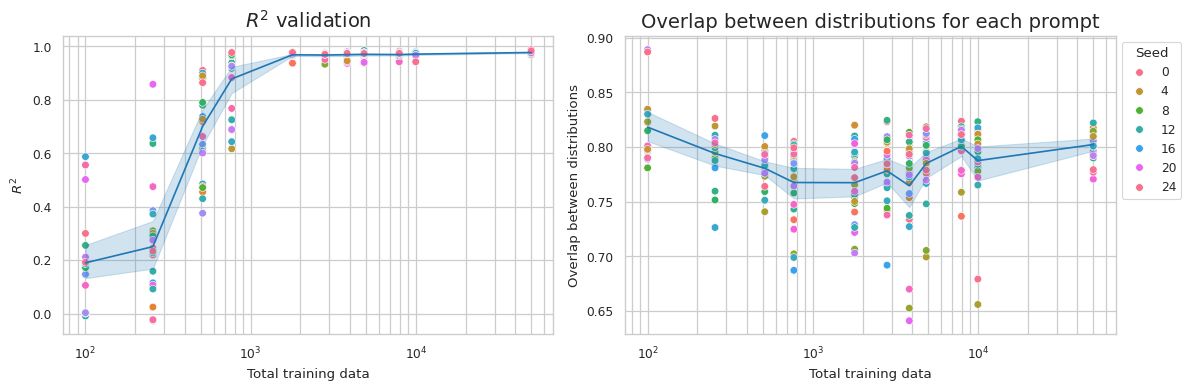

In [ ]:
if ('Log Total data' in cols_varying) or ('total_ds_max' in cols_varying):
    sns.set_context("paper")
    sns.set_style("whitegrid")

    df_hpos['Overlap adaptation mean'] = df_hpos['Overlap adaptation'].apply(
        lambda x: np.nanmean([np.nan if v is None else v for v in x['mean']]) if type(x) != str else x)
    filt = df_hpos['total_ds'] < 1e5
    
    seed_min, seed_max = np.min(df_hpos[['seed_train', 'seed_dataset']]), np.max(df_hpos[['seed_train', 'seed_dataset']])
    df_hpos['Seed'] = df_hpos[['seed_train', 'seed_dataset']].T.apply(lambda x: 
        dict(zip(list(itertools.product(range(seed_min, seed_max+1), range(seed_min, seed_max+1))), range(seed_max*seed_max)))[tuple(x)])

    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    sns.scatterplot(data=df_hpos[filt], x='total_ds',
                    hue='Seed',
                    palette='husl',
                    y='R2_test', ax=axs[0], s=30, legend=False)
    axs[0].grid(True, which='both', linewidth=0.9)
    sns.lineplot(data=df_hpos[filt], x='total_ds', y='R2_test', ax=axs[0])
    axs[0].set_xscale('log')
    axs[0].set_xlabel('Total training data')  # , fontsize=12)
    axs[0].set_ylabel(r'$R^2$')  # , fontsize=12)
    axs[0].set_title(r'$R^2$ validation', fontsize=14)

    # df_plot_overlap = pd.DataFrame(df_hpos['Overlap adaptation'].apply(lambda x: np.array([np.nan if v is None else v for v in x['mean']]) if type(x) != str else x).explode().values.reshape(-1, n_categories).astype(float),
    #                                columns=np.arange(n_categories))
    # df_plot_overlap['total_ds'] = df_hpos['total_ds'].values
    # df_plot_overlap = df_plot_overlap.melt(
    #     id_vars=['total_ds'], var_name='Prompt condition', value_name='Overlap adaptation mean')
    # filt = df_plot_overlap['total_ds'] < 1e5
    g = sns.scatterplot(data=df_hpos[filt], x='total_ds', y='Overlap adaptation mean',
                        hue='Seed', palette='husl',
                        ax=axs[1], s=30)
    axs[1].grid(True, which='both', linewidth=0.9)
    sns.lineplot(data=df_hpos[filt], x='total_ds',
                 y='Overlap adaptation mean', ax=axs[1])
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title='Seed')
    axs[1].set_xscale('log')
    axs[1].set_xlabel('Total training data')
    axs[1].set_ylabel('Overlap between distributions')
    axs[1].set_title(
        'Overlap between distributions for each prompt', fontsize=14)

    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, 'r2_vs_total_data.png'),
                dpi=300, bbox_inches='tight', transparent=True)

    # fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    # sns.scatterplot(data=df_hpos, x='total_ds_max', y=f'KDE {objective_chosen} min', ax=axs[0])
    # axs[0].set_xscale('log')
    # axs[0].set_xlabel('Total training data')
    # axs[0].grid(True, which='both', linewidth=0.9)
    # sns.scatterplot(data=df_hpos, x='total_ds_max', y=f'KDE {objective_chosen} mean', ax=axs[1])
    # axs[1].set_xscale('log')
    # axs[1].set_xlabel('Total training data')
    # axs[1].grid(True, which='both', linewidth=0.9)

# Confounding

In [ ]:
fn_varying = config_run['fn_varying'].replace('notebooks/', '')

hpos_to_vary_together = load_json_as_dict(fn_varying)['hpos_to_vary_together']
# hpos_to_vary_together = [{
#     'Objective': [('adaptation',), ('Log sensitivity',), ('Log sensitivity', 'Log precision')],
#     'prep_y_categorical': [False, True],
#     'use_kl_div': [True],
#     # 'kl_weight': [5e-5, 1e-4, 2.5e-4, 4e-4, 5e-4],
#     'kl_weight (x10e-4)': np.array([5e-5, 1e-4, 2.5e-4, 4e-4, 5e-4]) * 1e3,
#     'threshold_early_val_acc': [0.995, 0.98, 0.96, 0.9],
# },
#     {
#     'use_contrastive_loss': [True],
#     'temperature': [0.1, 0.5, 1, 1.5, 2, 4, 8],
#     'threshold_similarity': [0.95, 0.9, 0.7, 0.5, 0.3, 0.1],
#     'power_factor_distance': [3, 4],
#     'threshold_early_val_acc': [0.995, 0.9]
# }]

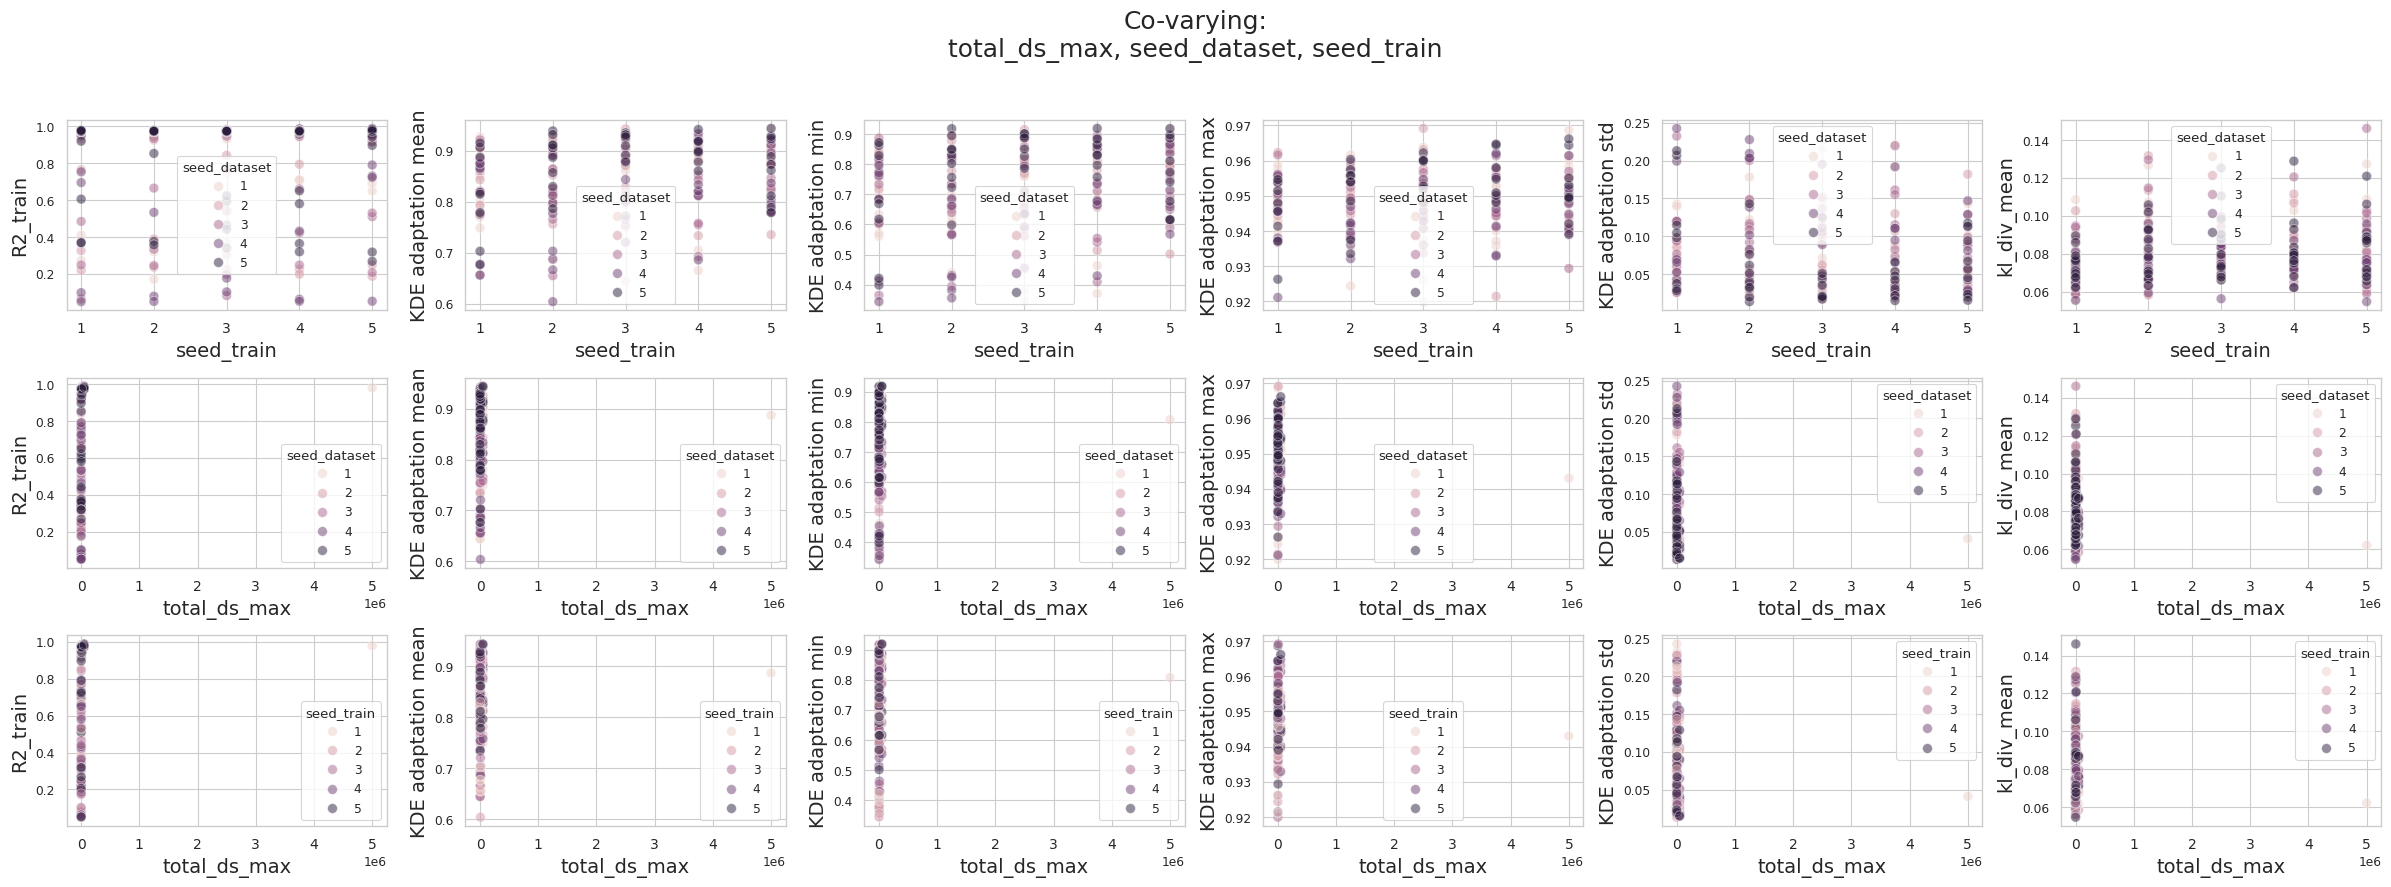

In [ ]:
for h in hpos_to_vary_together:
    h_keys = [c for c in h.keys() if (c in df_hpos.columns) and (df_hpos[c].nunique() > 1)]
    if 'kl_weight (x10e-4)' in h.keys():
        h_keys = h_keys + ['kl_weight (x10e-4)']
    combinations = sorted(set([tuple(sorted([i, j]))
                          for i, j in itertools.combinations(h_keys, 2)]))
    ncols = len(cols_outmetric)
    nrows = len(combinations)
    if len(combinations) > 0:
        fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
        if nrows == 1:
            axes = axes[None, :]
        for i, (k1, k2) in enumerate(combinations):
            if 'seed' in k1:
                k1, k2 = k2, k1
            for j, kj in enumerate(cols_outmetric):
                if df_hpos[k1].dtype == object and (df_hpos[k2].iloc[0] not in ['True', 'False']) and (k2 != 'kl_weight (x10e-4)'):
                    f = sns.barplot
                    # f = sns.violinplot
                    kwargs = {'palette': 'viridis'}
                else:
                    f = sns.scatterplot
                    kwargs = {'s': 50, 'alpha': 0.5}
                    # k2 == 'threshold_early_val_acc':
                    if df_hpos[k2].dtype in [float, np.float32, np.float64]:
                        kwargs.update({'palette': 'viridis'})
                
                if 'temperature' in k1:
                    axes[i, j].set_xscale('log')

                if 'Overlap' in kj:
                    d_plot = df_hpos[[k1, kj, k2]]
                    d_plot[kj] = d_plot[kj].apply(lambda x: np.nanmean(x))
                    f(data=d_plot, x=k1, y=kj, hue=k2, ax=axes[i, j],
                        **kwargs)
                else:
                    f(data=df_hpos, x=k1, y=kj, hue=k2, ax=axes[i, j],
                      #   legend=(j == (ncols - 1)),
                      **kwargs)

                axes[i, j].tick_params(axis='x', labelsize=10)
                axes[i, j].set_xlabel(k1, fontsize=14)
                axes[i, j].set_ylabel(kj, fontsize=14)
        plt.suptitle('Co-varying:\n' + ', '.join(h_keys), fontsize=18)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig(os.path.join(top_write_dir, 'varying_confounding.png'),
            dpi=300, bbox_inches='tight', transparent=True)

# Zoom in on KL weight 

In [ ]:
choose_kl = [0.5]
choose_objective = ['Log sensitivity', ('Log sensitivity,\nLog precision')]

filt_kl = df_hpos['kl_weight (x10e-4)'].isin(choose_kl) & df_hpos['Objective'].isin(
    choose_objective) & df_hpos['run_successful'] & df_hpos['filename_saved_model'].apply(
        lambda x: os.path.exists(os.path.join(os.path.dirname(x), 'sampled_cond.npy'))) & df_hpos['filename_saved_model'].apply(lambda x: os.path.exists(os.path.join(os.path.dirname(x), 'analytics.json')))


df_train_tables = {}
for k in df_hpos[filt_kl]['filenames_train_table'].unique():
    fn = r['filenames_train_table'].replace('notebooks/', '')
    df_train_table = pd.read_json(fn) if fn.endswith(
        '.json') else pd.read_csv(fn)
    df_train_table['Log sensitivity'] = np.log(
        df_train_table['sensitivity'])
    df_train_table['Log precision'] = np.log(
        df_train_table['precision'])
    df_train_tables[k] = df_train_table

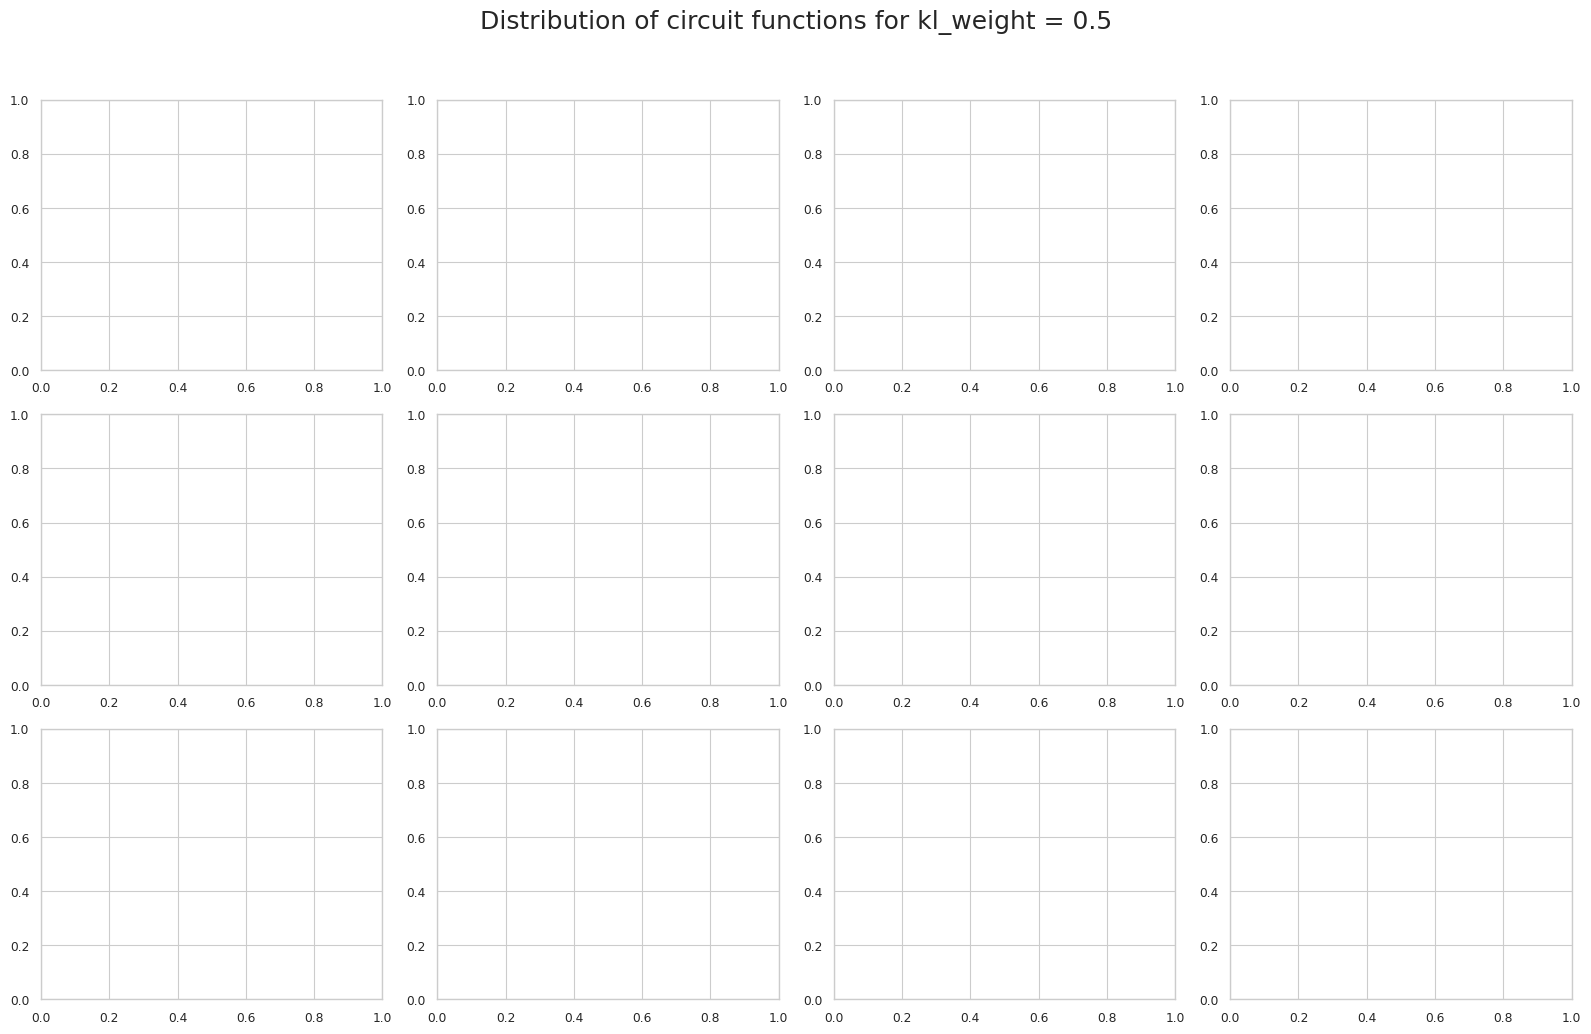

In [ ]:
def get_og_sample_cond(sampled_cond, df_train_tables, r):
    data = df_train_tables[r['filenames_train_table']]
    analytic = data[(data['sample_name'] == 'RNA_2') & (data['response_time'] <
                                                        r['filt_response_time_perc_max']*data['response_time'].max())][r['objective_col']]
    analytic = np.where(np.isinf(analytic), np.nan, analytic)

    a_range = (np.nanmax(analytic) - np.nanmin(analytic))
    a_min = np.nanmin(analytic) - a_range * 0.1
    a_max = np.nanmax(analytic) + a_range * 0.1

    cond = np.interp(sampled_cond, (sampled_cond.min(),
                     sampled_cond.max()), (a_min, a_max))
    return cond


nrows = 3  # int(np.ceil(np.sqrt(len(df_hpos[filt_kl]))))
ncols = 4  # int(np.ceil(np.sqrt(len(df_hpos[filt_kl]))))
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.5*nrows))
for i, (i_df, r) in enumerate(df_hpos[filt_kl].iterrows()):
    curr_dir = os.path.dirname(r['filename_saved_model'])
    fn_sample = os.path.join(curr_dir, 'sampled_cond.npy')
    fn_analytics = os.path.join(curr_dir, 'analytics.json')

    sampled_cond = np.load(fn_sample)
    sampled_cond = sampled_cond.reshape(np.prod(sampled_cond.shape[:-1]), -1)
    analytics = load_json_as_dict(fn_analytics)
    a = np.concatenate([np.array(analytics[k])[..., output_idx][:, None]
                       for k in r['objective_col']], axis=-1).reshape(*sampled_cond.shape)
    a_resp = np.array(
        analytics['response_time'])[..., output_idx]
    idxs_good = np.where(
        a_resp < r['filt_response_time_perc_max']*a_resp.max())[0]
    cond = get_og_sample_cond(sampled_cond, df_train_tables, r)

    sns.kdeplot(x=a[idxs_good].flatten(), hue=cond[idxs_good].flatten().astype(
        np.float32), palette='viridis', ax=axs.flat[i])
    axs.flat[i].set_title(
        f'Precision = {r["precision"]:.2f}, Recall = {r["recall"]:.2f}, {"continuous" if r["prep_y_categorical"] != "True" else "categorical"}')
    axs.flat[i].set_xlabel(", ".join(r["objective_col"]))

plt.suptitle(
    'Distribution of circuit functions for kl_weight = 0.5', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(top_write_dir, 'distribution_circuit_functions.png'),
            dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
if len(df_hpos[filt_kl]):
    obj_cols = flatten_listlike(list([df_hpos[df_hpos['Objective'] == o]['objective_col'].iloc[0] for o in df_hpos['Objective'].unique()]))
    # obj_cols = flatten_listlike(df_hpos['objective_col'].apply(tuple).unique())
    fig, axs = plt.subplots(1, len(obj_cols), figsize=(4*len(obj_cols), 3*1))
    for i, obj_col in enumerate(obj_cols):
        ax = axs.flat[i]
        d = df_train_tables[r['filenames_train_table']]
        if 'adaptation' not in d:
            d['adaptation'] = calculate_adaptation(
                np.array(d['sensitivity']), np.array(d['precision']), alpha=2)
        d = d[(d['sample_name'] == 'RNA_2') & (d['response_time'] < r['filt_response_time_perc_max']*d['response_time'].max())]
        if type(obj_col) != str:
            # sns.kdeplot(d[obj_col].to_numpy().flatten(), ax=ax)
            for o in obj_col:
                sns.kdeplot(d, x=o, ax=ax, label=o)
                plt.legend()
        else:
            sns.kdeplot(d, x=obj_col, ax=ax)
        ax.set_title(obj_col)
        
    plt.suptitle('Training data', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(top_write_dir, 'distribution_training_data.png'), dpi=300, bbox_inches='tight', transparent=True)
